In [1]:
import os

import torch

from src.agents import ContinuosActorCritic
from src.networks import ActorCriticNetwork
from src.pv_env import History, PVEnv
from src.reward import RewardDeltaPower, DiscreteRewardDeltaPower

PV_PARAMS_PATH = os.path.join("parameters", "01_pvarray.json")
WEATHER_TRAIN_PATH = os.path.join("data", "weather_sim.csv")
WEATHER_TEST_PATH = os.path.join("data", "weather_real.csv")
PVARRAY_CKP_PATH = os.path.join('data', '01_pvarray_iv.json')
AGENT_CKP_PATH = os.path.join("models", "02_mppt_ac.tar")
LEARNING_RATE = 0.0001
ENTROPY_BETA = 0.001
GAMMA = 0.99
N_STEPS = 4
BATCH_SIZE = 32

In [2]:
env = PVEnv.from_file(
    PV_PARAMS_PATH,
    WEATHER_TRAIN_PATH,
    pvarray_ckp_path=PVARRAY_CKP_PATH,
    states=["v_norm", "i_norm", "deg"],
    # reward_fn=RewardDeltaPower(1, 0.9),
    reward_fn=DiscreteRewardDeltaPower(),
)
test_env = PVEnv.from_file(
    PV_PARAMS_PATH,
    WEATHER_TRAIN_PATH,
    pvarray_ckp_path=PVARRAY_CKP_PATH,
    states=["v_norm", "i_norm", "deg"],
    # reward_fn=RewardDeltaPower(1, 0.9),
    reward_fn=DiscreteRewardDeltaPower(),
)

INFO 2020-11-25 20:06:29,988 Dictionary readed from parameters\01_pvarray.json
INFO 2020-11-25 20:06:29,989 Starting MATLAB engine . . .
INFO 2020-11-25 20:06:35,835 MATLAB engine initializated.
INFO 2020-11-25 20:06:57,798 Model loaded succesfully.
INFO 2020-11-25 20:06:57,834 Dictionary readed from data\01_pvarray_iv.json
INFO 2020-11-25 20:06:57,838 Reading data\weather_sim.csv . . .
INFO 2020-11-25 20:06:57,853 Dictionary readed from parameters\01_pvarray.json
INFO 2020-11-25 20:06:57,854 Starting MATLAB engine . . .
INFO 2020-11-25 20:07:03,240 MATLAB engine initializated.
INFO 2020-11-25 20:07:24,827 Model loaded succesfully.
INFO 2020-11-25 20:07:24,865 Dictionary readed from data\01_pvarray_iv.json
INFO 2020-11-25 20:07:24,868 Reading data\weather_sim.csv . . .


In [3]:
device = torch.device("cpu")
net = ActorCriticNetwork(
    input_size=env.observation_space.shape[0],
    n_actions=env.action_space.shape[0]
).to(device)
agent = ContinuosActorCritic(
    env=env,
    test_env=test_env,
    net=net,
    device=device,
    gamma=GAMMA,
    beta_entropy=ENTROPY_BETA,
    lr=LEARNING_RATE,
    n_steps=N_STEPS,
    batch_size=BATCH_SIZE,
    # chk_path=AGENT_CKP_PATH,
    chk_path=None,
)

In [15]:
agent.learn(steps=10, verbose_every=100, save_every=0)

100%|██████████| 10/10 [07:32<00:00, 45.28s/it]


INFO 2020-11-25 21:27:03,660 Calculating true MPP . . .
Calculating true MPP: 100%|##########| 834/834 [00:01<00:00, 631.98it/s]
INFO 2020-11-25 21:27:04,982 Running P&O, step=0.2 volts . . .
Calculating PO: 100%|##########| 834/834 [00:00<00:00, 119127.15it/s]


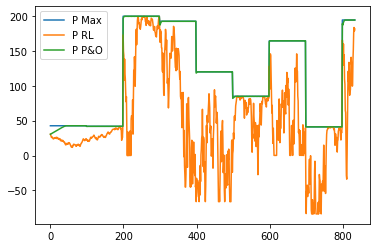

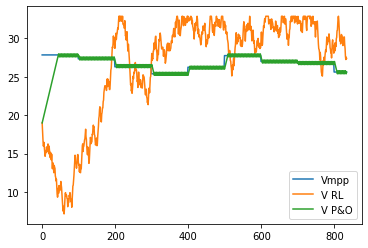

INFO 2020-11-25 21:27:05,649 PO Efficiency=99.20683489086406
INFO 2020-11-25 21:27:05,650 RL Efficiency=39.357460912177515


In [16]:
agent.exp_train_source.play_episode()
env.render_vs_true(po=True)

INFO 2020-11-25 21:27:21,836 Calculating true MPP . . .
Calculating true MPP: 100%|##########| 834/834 [00:01<00:00, 679.62it/s]
INFO 2020-11-25 21:27:23,067 Running P&O, step=0.2 volts . . .
Calculating PO: 100%|##########| 834/834 [00:00<00:00, 139015.60it/s]


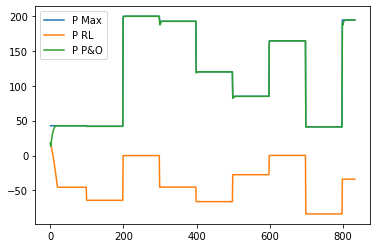

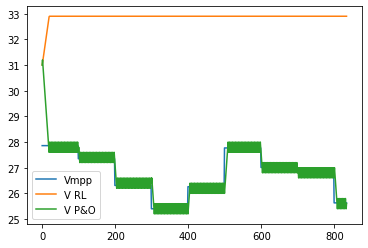

INFO 2020-11-25 21:27:23,982 PO Efficiency=99.43237209712157
INFO 2020-11-25 21:27:23,983 RL Efficiency=-67.46912472409247


In [17]:
agent.exp_test_source.play_episode()
test_env.render_vs_true(po=True)

In [7]:
obs = env.reset()
agent.policy(obs), agent.test_policy(obs), agent.net(torch.tensor(obs, dtype=torch.float32))

(0.68383,
 0.08450493,
 (tensor([0.0845], grad_fn=<AddBackward0>),
  tensor([0.7182], grad_fn=<SoftplusBackward>),
  tensor([-0.0752], grad_fn=<AddBackward0>)))

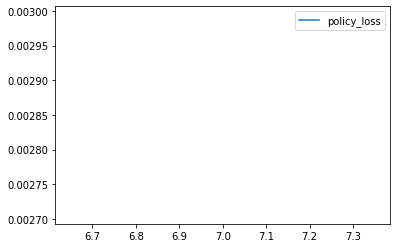

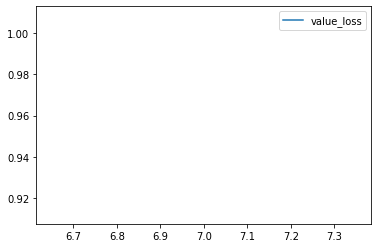

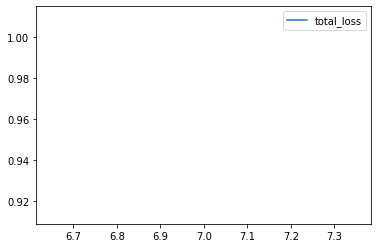

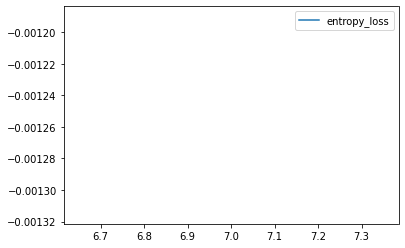

In [8]:
agent.plot_performance(['policy_loss', 'value_loss', 'total_loss', 'entropy_loss'])